In [2]:
%matplotlib inline

KMRの確率進化動学の実装である。
関数kmr_markov_matrixはmodeが0で与えられるなら逐次型の、1で与えられるなら同時型で行動改定する。

In [94]:
"""
Author:
KMR (Kandori-Mailath-Rob) Model
"""
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from numpy import searchsorted
from scipy.stats import binom

def kmr_markov_matrix(p, N, epsilon,mode=0):
    """
    Generate the transition probability matrix for the KMR dynamics with
    two acitons.
    """    
    if mode == 0:
        P = seq_rev(p, N, epsilon)
        return P.seq_rev()
    elif mode == 1:
        P = sim_rev(p, N, epsilon)
        return P.sim_rev()
    else:
        return 0
    
class seq_rev():

    def __init__(self, p, N, epsilon):
        init_P = np.zeros((N+1, N+1), dtype=float)
        self.emp_P = init_P
        self.prb = p
        self.num_p = N
        self.irrg_chng = epsilon * 1/2
        self.nrml_act = 1 - self.irrg_chng

    def dec_rct(self, k):
        N = self.num_p
        p = self.prb 
        if (k-1)/(N-1) < p:
            p = 1
            return p
        elif (k-1)/(N-1) == p:
            p = 1/2
            return float(p)
        else:
            return 0
        
    def inc_rct(self, k):
        N = self.num_p
        p = self.prb 
        if k/(N-1) > p:
            p = 1
            return p
        elif k/(N-1) == p:
            p = 1/2
            return p
        else:
            return 0
        
    def seq_rev(self):
        N = self.num_p
        P = self.emp_P
        P[0][1] = self.irrg_chng
        P[N][N-1] = self.irrg_chng
        P[0][0], P[N][N] = 1 - P[0][1], 1 - P[N][N-1]
        for i in range(1,N):
            i = float(i)
            get1p = i/N
            get0p = (N-i)/N
            P[i][i-1] = get1p * (self.irrg_chng + self.nrml_act*self.dec_rct(i))
            P[i][i+1] = get0p * (self.irrg_chng + self.nrml_act*self.inc_rct(i))
            P[i][i] = 1.0 - P[i][i-1] - P[i][i+1]
        seq_P = P
        return seq_P
    

class sim_rev():

    def __init__(self, p, N, epsilon):
        init_P = np.zeros((N+1, N+1), dtype=float)
        self.emp_P = init_P
        self.prb = p
        self.num_p = N
        self.irrg_chng = epsilon * 1/2
        self.nrml_act = 1 - self.irrg_chng
        
    def sim_rev(self):
        N = self.num_p
        P = self.emp_P
        X = [i for i in range(N+1)]
        for i in range(0,N+1):
            i = float(i)
            N2 = float(N)
            k = i/N2
            if k < self.prb:
                pmf = binom.pmf(X, N, self.irrg_chng)
                for k in range(N+1):
                    P[i][k] = round(pmf[k], 5)
            elif k == self.prb:
                pmf = binom.pmf(X, N, 1/2)
                for k in range(N+1):
                    P[i][k] = round(pmf[k], 5)
            else:
                pmf = binom.pmf(X, N, self.nrml_act)
                for k in range(N+1):
                    P[i][k] = round(pmf[k], 5)
        sim_P = P
        return sim_P
        
class KMR():
    """
    Class representing the KMR dynamics with two actions.
    """
    def __init__(self, p, N, epsilon, mode=0):
        self.p = kmr_markov_matrix(p, N, epsilon, mode)
        self.mc = qe.MarkovChain(self.p)
        self.state = self.sample_path
        self.N = N
        
    def plot1(self):
        fig, ax = plt.subplots()
        ax.set_ylim(0, 6)
        ax.plot(t)
        show = plt.show()
        return show
    
    def sample_path(self, init=0, sample_size=100000, plot=0):
        """
        See Section: DocStrings below
        """
        
        P = self.p
        
        n = len(P)

        # CDFs, one for each row of P
        cdfs = np.empty((n, n), order='C')  # see issue #137#issuecomment-96128186
        np.cumsum(P, axis=-1, out=cdfs)

        # Random values, uniformly sampled from [0, 1)
        u = np.random.random(size=sample_size)

        # === set up array to store output === #
        X = np.empty(sample_size, dtype=int)
        if isinstance(init, int):
            X[0] = init
        else:
            cdf0 = np.cumsum(init)
            X[0] = searchsorted(cdf0, u[0])

        # === generate the sample path === #
        for t in range(sample_size-1):
            X[t+1] = searchsorted(cdfs[X[t]], u[t+1])
            
        if plot == 1:
            fig, ax = plt.subplots()
            ax.set_ylim(-1, self.N+1)
            ax.plot(X)
            show = plt.show()
            return X, show
        else: 
            return X
    
    def plot(self):
        fig, ax = plt.subplots()
        ax.set_ylim(-1, self.N+1)
        ax.plot(self.sample_path())
        show = plt.show()
        return show

    def compute_stationary_distribution(self):
        x = []
        # mc.stationary_distributions の戻り値は2次元配列．
        # 各行に定常分布が入っている (一般には複数)．
        # epsilon > 0 のときは唯一，epsilon == 0 のときは複数ありえる．
        # espilon > 0 のみを想定して唯一と決め打ちするか，
        # 0か正かで分岐するかは自分で決める．
        self.mc.stationary_distributions[0]  # これは唯一と決め打ちの場合
        for i in range(len(self.mc.stationary_distributions[0])):
            x.append(round(self.mc.stationary_distributions[0][i], 5))
        return x
                     

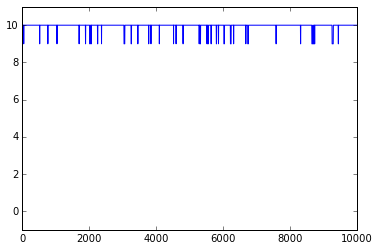

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 0.00107, 0.04757, 0.95135]

In [115]:
siq = KMR(0.333, 10, 0.01, mode=0)
siq.sample_path(init=10,sample_size=10000, plot=1)
siq.compute_stationary_distribution()

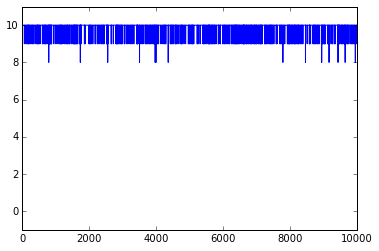

[0.95112, 0.04779, 0.00108, 1e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [117]:
sim = KMR(0.333, 10, 0.01, mode=1)
sim.sample_path(init=10,sample_size=10000,plot=1)
sim.compute_stationary_distribution()